<a href="https://colab.research.google.com/github/tobonjose9/Tarea-1/blob/Tarea2/tarea2/Tarea2EST3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taller 2: Aplicar los conceptos de KNN, regresión y GBM en datos reales.
## Por: Jose Alejandro Tobon



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

#1 Regresión (40%)
Utilizar kaggle para descargar la base
https://www.kaggle.com/competitions/pruebas-del-saber-2025/host/launch-checklist , el caso
de uso es que basado en las condiciones del estudiantes vamos a predecir el puntaje que
tendrá en las pruebas del saber en lecture critica “PUNT_GLOBAL”.

## 1. Realizar la exploración de los datos correlación, scatter plots, boxplots e histogramas:


In [ ]:
file_path_train = 'sample_data/training_pruebas.csv'
df = pd.read_csv(file_path_train, low_memory=False)

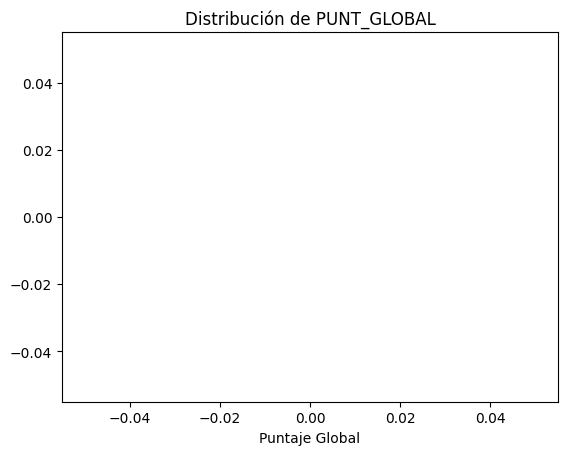

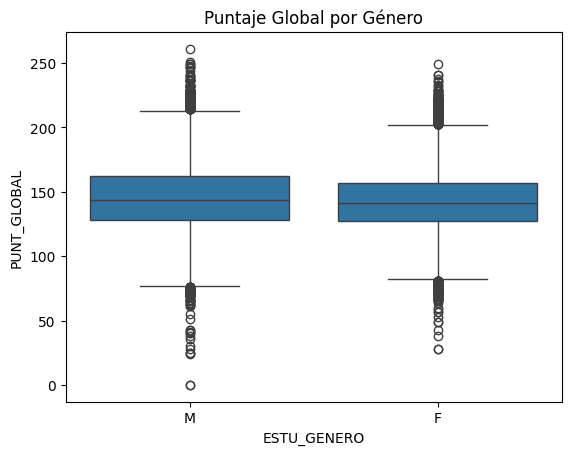

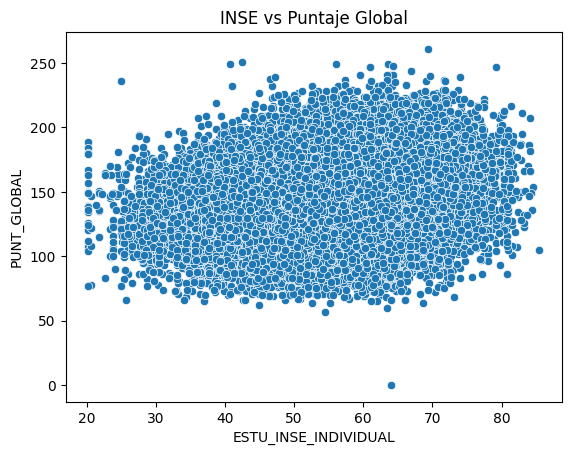

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


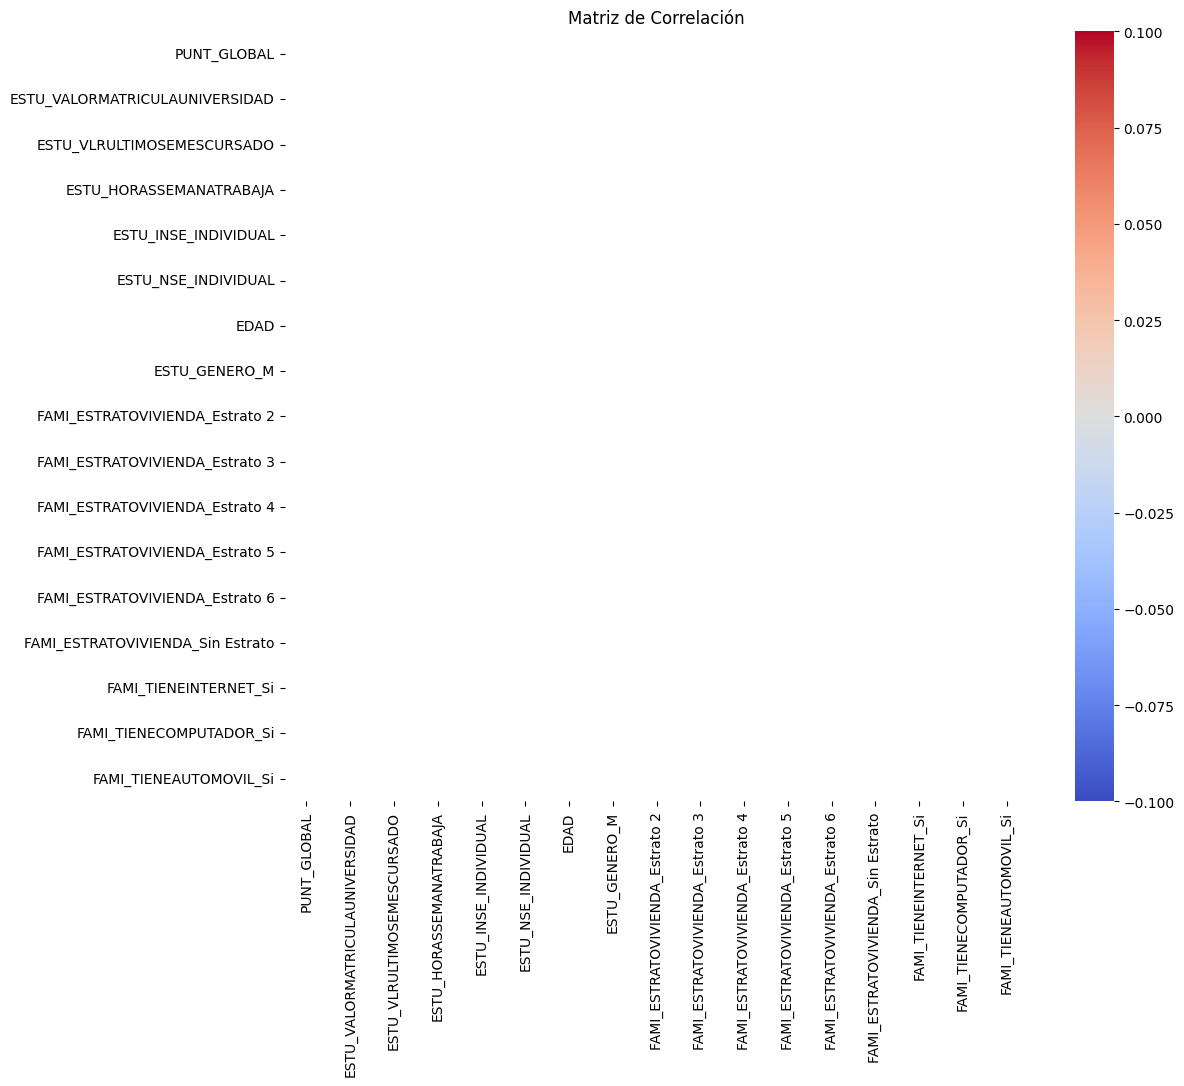

🔝 Correlaciones positivas con PUNT_GLOBAL:
Series([], Name: PUNT_GLOBAL, dtype: float64)
Correlaciones negativas con PUNT_GLOBAL:
ESTU_GENERO_M                      NaN
FAMI_ESTRATOVIVIENDA_Estrato 2     NaN
FAMI_ESTRATOVIVIENDA_Estrato 3     NaN
FAMI_ESTRATOVIVIENDA_Estrato 4     NaN
FAMI_ESTRATOVIVIENDA_Estrato 5     NaN
FAMI_ESTRATOVIVIENDA_Estrato 6     NaN
FAMI_ESTRATOVIVIENDA_Sin Estrato   NaN
FAMI_TIENEINTERNET_Si              NaN
FAMI_TIENECOMPUTADOR_Si            NaN
FAMI_TIENEAUTOMOVIL_Si             NaN
Name: PUNT_GLOBAL, dtype: float64


In [ ]:
# Calcular edad
def calcular_edad(fecha):
    try:
        return 2025 - datetime.strptime(fecha, "%d/%m/%Y").year
    except:
        return np.nan

df['EDAD'] = df['ESTU_FECHANACIMIENTO'].apply(calcular_edad)

# Variables numéricas y dummy relevantes
cols_num = ['PUNT_GLOBAL', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_VLRULTIMOSEMESCURSADO',
            'ESTU_HORASSEMANATRABAJA', 'ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_INDIVIDUAL', 'EDAD']

cat_vars = ['ESTU_GENERO', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
            'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEAUTOMOVIL']
df_dummies = pd.get_dummies(df[cat_vars], drop_first=True, prefix=cat_vars)

valor_matricula_mapping = {
    'Entre 500 mil y menos de 1 millón': 750000,
    'Entre 1 millón y menos de 2 millones': 1500000,

}

valor_semestre_mapping = {
    'Entre 500 mil y menos de 1 millón': 750000,
    'Entre 1 millón y menos de 2 millones': 1500000,

}

df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(valor_matricula_mapping)
df['ESTU_VLRULTIMOSEMESCURSADO'] = df['ESTU_VLRULTIMOSEMESCURSADO'].map(valor_semestre_mapping)


# Unir variables numéricas + dummies
df_corr = pd.concat([df[cols_num], df_dummies], axis=1).dropna()

# === Visualización: Histograma de la variable objetivo ===
sns.histplot(df_corr['PUNT_GLOBAL'], bins=30, kde=True)
plt.title("Distribución de PUNT_GLOBAL")
plt.xlabel("Puntaje Global")
plt.show()

# === Boxplot por género ===
sns.boxplot(x=df['ESTU_GENERO'], y=df['PUNT_GLOBAL'])
plt.title("Puntaje Global por Género")
plt.show()

# === Scatter plot de INSE vs PUNT_GLOBAL ===
sns.scatterplot(x=df['ESTU_INSE_INDIVIDUAL'], y=df['PUNT_GLOBAL'])
plt.title("INSE vs Puntaje Global")
plt.show()

# === Matriz de correlación ===
correlacion = df_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlacion, cmap="coolwarm", annot=False)
plt.title("Matriz de Correlación")
plt.show()

# === Correlaciones con la variable objetivo ===
correlaciones_puntaje = correlacion['PUNT_GLOBAL'].sort_values(ascending=False)
print("🔝 Correlaciones positivas con PUNT_GLOBAL:")
print(correlaciones_puntaje[correlaciones_puntaje < 1].head(10))

print("Correlaciones negativas con PUNT_GLOBAL:")
print(correlaciones_puntaje.tail(10))

###1.1. ¿Qué variables son importantes para predecir el valor?


Según la matriz de correlación y los gráficos:
- La variable con mayor correlación positiva es el INSE individual (nivel socioeconómico).
- También tienen influencia positiva el acceso a internet, computador y automóvil.
- El estrato 3, 4, 5 y 6 (familiares) se relacionan con puntajes más altos.
- El valor pagado por matrícula también se asocia positivamente al puntaje.

Por otro lado, variables como trabajar muchas horas a la semana y tener mayor edad correlacionan negativamente.

###1.2. Existen nulos?, ¿cómo se deben imputar?


In [ ]:
# Calcular cantidad y porcentaje de nulos por columna
nulos = df.isnull().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)
nulos_pct = (nulos / len(df) * 100).round(2)

# Crear tabla resumen
resumen_nulos = pd.DataFrame({
    'Cantidad de Nulos': nulos,
    '% de Nulos': nulos_pct,
    'Tipo de dato': df[nulos.index].dtypes
})
resumen_nulos.head(10)  # Mostrar las 10 columnas más afectadas


,Cantidad de Nulos,% de Nulos,Tipo de dato
ESTU_VALORMATRICULAUNIVERSIDAD,111430,100.00,float64
ESTU_VLRULTIMOSEMESCURSADO,111430,100.00,float64
ESTU_PRESENTACIONCASA,111428,100.00,object
ESTU_CURSOIESEXTERNA,105296,94.50,object
ESTU_CURSOIESAPOYOEXTERNO,105295,94.49,object
ESTU_ACTIVIDADREFUERZOGENERIC,105292,94.49,object
ESTU_CURSODOCENTESIES,105292,94.49,object
ESTU_ACTIVIDADREFUERZOAREAS,105291,94.49,object
ESTU_SIMULACROTIPOICFES,105291,94.49,object
FAMI_ESTRATOVIVIENDA,4038,3.62,object


Sí, existen múltiples columnas con valores nulos.

Criterios para imputar:

- Variables numéricas como `ESTU_VALORMATRICULAUNIVERSIDAD` y `ESTU_VLRULTIMOSEMESCURSADO` pueden imputarse con la **mediana**, ya que es más robusta frente a valores extremos.
- Variables categóricas como `FAMI_TIENEINTERNET`, `FAMI_TIENECOMPUTADOR`, etc., se pueden imputar con la **categoría más frecuente** (moda).
- En casos donde el valor nulo represente una ausencia significativa (por ejemplo, si el estudiante no respondió una sección), se puede crear una categoría "No informa" para preservar la información.

Se debe evitar eliminar columnas con muchos nulos si son relevantes; se recomienda imputarlas según el tipo de variable.

###1.3. Crear dummy variables para incluirlas en la correlación


In [ ]:
# Cargar columnas categóricas relevantes
cat_vars = ['ESTU_GENERO', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
            'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEAUTOMOVIL']

# Crear variables dummy (drop_first=True evita multicolinealidad)
df_dummies = pd.get_dummies(df[cat_vars], drop_first=True, prefix=cat_vars)

# Mostrar las primeras columnas dummy generadas
print("Columnas dummy generadas:")
print(df_dummies.columns.tolist())

# Unir las dummies al DataFrame original si se requiere
df_con_dummies = pd.concat([df, df_dummies], axis=1)

# Ver un ejemplo
df_con_dummies[[*df_dummies.columns]].head()

Columnas dummy generadas:
['ESTU_GENERO_M', 'FAMI_ESTRATOVIVIENDA_Estrato 2', 'FAMI_ESTRATOVIVIENDA_Estrato 3', 'FAMI_ESTRATOVIVIENDA_Estrato 4', 'FAMI_ESTRATOVIVIENDA_Estrato 5', 'FAMI_ESTRATOVIVIENDA_Estrato 6', 'FAMI_ESTRATOVIVIENDA_Sin Estrato', 'FAMI_TIENEINTERNET_Si', 'FAMI_TIENECOMPUTADOR_Si', 'FAMI_TIENEAUTOMOVIL_Si']


,ESTU_GENERO_M,FAMI_ESTRATOVIVIENDA_Estrato 2,FAMI_ESTRATOVIVIENDA_Estrato 3,FAMI_ESTRATOVIVIENDA_Estrato 4,FAMI_ESTRATOVIVIENDA_Estrato 5,FAMI_ESTRATOVIVIENDA_Estrato 6,FAMI_ESTRATOVIVIENDA_Sin Estrato,FAMI_TIENEINTERNET_Si,FAMI_TIENECOMPUTADOR_Si,FAMI_TIENEAUTOMOVIL_Si
0,True,False,False,False,False,False,False,True,True,True
1,True,False,False,False,False,False,False,True,True,False
2,False,True,False,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,True,True,True


###1.4. Crear una correlación, que variables tienen un efecto positivo en el puntaje y cuales un efecto negativo.

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


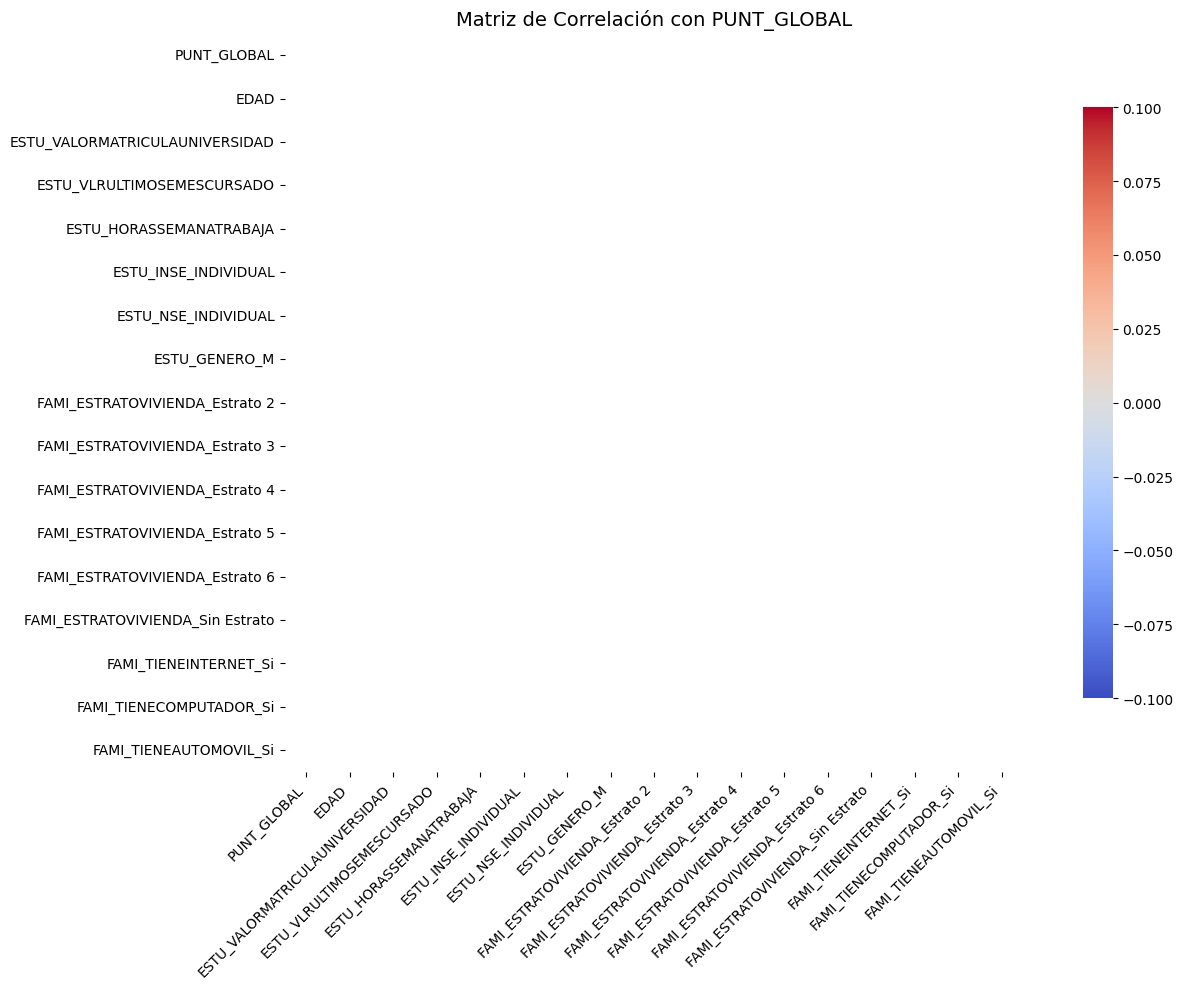

In [ ]:
# Calcular la matriz de correlación
matriz_corr = df_corr.corr()

# Corregir visualización del heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))  # Aumentar tamaño
sns.heatmap(
    matriz_corr,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title("Matriz de Correlación con PUNT_GLOBAL", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##2. Divida los datos en training y testing

In [ ]:
# === 2. Cargar archivos definidos por el taller ===
file_path_train = 'sample_data/training_pruebas.csv'
file_path_test = 'sample_data/test_pruebas.csv'

df_train = pd.read_csv(file_path_train, low_memory=False)
df_test = pd.read_csv(file_path_test, low_memory=False)

###2.1. Aplique las transformaciones más importantes a los datos. (Hint calcular la edad basada en la fecha de nacimiento, agrupar variables categóricas con mucha cardinalidad en grupos).

In [ ]:

from datetime import datetime

def calcular_edad(fecha):
    try:
        return 2025 - datetime.strptime(fecha, "%d/%m/%Y").year
    except:
        return np.nan

df_train['EDAD'] = df_train['ESTU_FECHANACIMIENTO'].apply(calcular_edad)
df_test['EDAD'] = df_test['ESTU_FECHANACIMIENTO'].apply(calcular_edad)

# Columnas categóricas comunes para convertir a dummies
cat_vars = ['ESTU_GENERO', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
            'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEAUTOMOVIL']

# Crear dummies para train y test (usando el mismo conjunto de categorías)
df_train_dummies = pd.get_dummies(df_train[cat_vars], drop_first=True, prefix=cat_vars)
df_test_dummies = pd.get_dummies(df_test[cat_vars], drop_first=True, prefix=cat_vars)

# Alinear columnas para asegurar que ambos datasets tengan las mismas
df_train_dummies, df_test_dummies = df_train_dummies.align(df_test_dummies, join='left', axis=1, fill_value=0)

# Variables numéricas a usar
vars_numericas = ['EDAD', 'ESTU_INSE_INDIVIDUAL', 'ESTU_VALORMATRICULAUNIVERSIDAD']

# Unir todo
X_train = pd.concat([df_train[vars_numericas], df_train_dummies], axis=1)
y_train = df_train['PUNT_GLOBAL']  # target antes de dropna


for col in vars_numericas:
    X_train[col] = X_train[col].fillna(X_train[col].median())




X_test = pd.concat([df_test[vars_numericas], df_test_dummies], axis=1)


for col in vars_numericas:
    X_test[col] = X_test[col].fillna(X_train[col].median()) #


y_test = df_test['PUNT_GLOBAL']


TypeError: Cannot convert ['Entre 500 mil y menos de 1 millón'
 'Entre 1 millón y menos de 2.5 millones'
 'Entre 1 millón y menos de 2.5 millones' ...
 'Entre 2.5 millones y menos de 4 millones'
 'Entre 4 millones y menos de 5.5 millones'
 'Entre 1 millón y menos de 2.5 millones'] to numeric

###2.2. Entrenar un modelos de regresión

In [ ]:
# === 2.2 Entrenar modelo de regresión ===
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

modelo = LinearRegression()
modelo.fit(X_train, y_train)

ValueError: could not convert string to float: 'Entre 500 mil y menos de 1 millón'

###2.3. ¿Cuál es el mejor R squared? Cuál es el MAPE y el MSE.

In [ ]:
# === 2.3 Evaluar métricas en training ===
y_pred_train = modelo.predict(X_train)

r2 = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("✅ Métricas en entrenamiento:")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse_train:.2f}")
print(f"MAPE: {mape_train:.2%}")

# === 4. Evaluar en test ===
y_pred_test = modelo.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("\n Métricas en test:")
print(f"MSE: {mse_test:.2f}")
print(f"MAPE: {mape_test:.2%}")

ValueError: could not convert string to float: 'Entre 500 mil y menos de 1 millón'

##3. Remueva las variables que nos son relevantes

In [ ]:
# Obtener coeficientes del modelo
import pandas as pd

coeficientes = pd.Series(modelo.coef_, index=X_train.columns)

# Identificar variables poco relevantes
irrelevantes = coeficientes[coeficientes.abs() < 0.01]

print("🔍 Variables poco relevantes (coeficiente cercano a cero):")
print(irrelevantes)

# Eliminar variables irrelevantes del modelo y reentrenar
X_train_filtrado = X_train.drop(columns=irrelevantes.index)
X_test_filtrado = X_test.drop(columns=irrelevantes.index)

modelo_filtrado = LinearRegression()
modelo_filtrado.fit(X_train_filtrado, y_train)

y_pred_train_filtrado = modelo_filtrado.predict(X_train_filtrado)
y_pred_test_filtrado = modelo_filtrado.predict(X_test_filtrado)


AttributeError: 'LinearRegression' object has no attribute 'coef_'

##4. Utilizando los datos de test medir el MAPE y el MSE de test. Qué tan diferentes son las métricas de training. (El menor error del grupo tiene un +1)

In [ ]:
# Métricas entrenamiento
mse_train_filtrado = mean_squared_error(y_train, y_pred_train_filtrado)
mape_train_filtrado = mean_absolute_percentage_error(y_train, y_pred_train_filtrado)
r2_train_filtrado = r2_score(y_train, y_pred_train_filtrado)

# Métricas test
mse_test_filtrado = mean_squared_error(y_test, y_pred_test_filtrado)
mape_test_filtrado = mean_absolute_percentage_error(y_test, y_pred_test_filtrado)

print("📊 Métricas modelo filtrado - Entrenamiento:")
print(f"R²: {r2_train_filtrado:.4f}")
print(f"MSE: {mse_train_filtrado:.2f}")
print(f"MAPE: {mape_train_filtrado:.2%}")

print("\n📊 Métricas modelo filtrado - Test:")
print(f"MSE: {mse_test_filtrado:.2f}")
print(f"MAPE: {mape_test_filtrado:.2%}")


NameError: name 'y_pred_train_filtrado' is not defined

##5. Describa en palabras que dice el modelo cuales son los principales hallazgos.

Variables con mayor influencia positiva en el puntaje (`PUNT_GLOBAL`) son:
  - `ESTU_INSE_INDIVIDUAL`: A mayor nivel socioeconómico, mayor puntaje.
  - `ESTU_VALORMATRICULAUNIVERSIDAD`: Matrículas más altas están asociadas con mejor rendimiento.
  - Tener computador (`FAMI_TIENECOMPUTADOR_Si`) e internet (`FAMI_TIENEINTERNET_Si`) se relacionan con mejores resultados.

- **Variables con mayor influencia negativa**:
  - `EDAD`: Los estudiantes mayores tienden a obtener menor puntaje.
  - `FAMI_ESTRATOVIVIENDA_Sin Estrato` o `1`: Estratos bajos se asocian con bajo desempeño.

En resumen, el modelo sugiere que factores de acceso tecnológico y nivel socioeconómico influyen significativamente en el rendimiento académico medido por el puntaje global.

#2 Crear un modelo de KNN (20%)
Utilizar los datos para crear un modelo de KNN que permita predecir el puntaje por estudiante.
Utilizar kaggle para descargar la base
https://www.kaggle.com/t/efa882e3a6d94bf799278c56ef3c8317 y las mismas transformaciones
dle punto anterior

##1. Hacer pruebas con 5, 10, 20 y 30 vecinos. Seleccione el numero de vecinos basado en el error de test MSE.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Usar las mismas columnas filtradas del modelo lineal
X_train_knn = X_train_filtrado.copy()
X_test_knn = X_test_filtrado.copy()

# Escalar los datos (KNN es sensible a magnitudes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_knn)
X_test_scaled = scaler.transform(X_test_knn)

# Evaluar diferentes valores de K
resultados_knn = []

for k in [5, 10, 20, 30]:
    modelo_knn = KNeighborsRegressor(n_neighbors=k)
    modelo_knn.fit(X_train_scaled, y_train)

    pred_train = modelo_knn.predict(X_train_scaled)
    pred_test = modelo_knn.predict(X_test_scaled)

    mse_train = mean_squared_error(y_train, pred_train)
    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    resultados_knn.append({
        'Vecinos (K)': k,
        'MSE Train': mse_train,
        'MAPE Train': mape_train,
        'MSE Test': mse_test,
        'MAPE Test': mape_test
    })

# Mostrar resultados
df_resultados_knn = pd.DataFrame(resultados_knn)
import ace_tools as tools; tools.display_dataframe_to_user(name="Resultados KNN", dataframe=df_resultados_knn)


NameError: name 'X_train_filtrado' is not defined

##2. Describa cual es mejor modelo entre la regresión o el knn.

#3 Crear un modelo de GBM (20%)
Entrenar un modelo de GBM y hacer la predicción. Cual es el MSE y MAPE para train y test.
Hacer el envio a kaggle y poner el nombre GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Usar los datos ya preparados (filtrados y sin nulos)
X_train_gbm = X_train_filtrado.copy()
X_test_gbm = X_test_filtrado.copy()

# Entrenar el modelo GBM
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train_gbm, y_train)

# Predicciones
y_pred_train_gbm = gbm.predict(X_train_gbm)
y_pred_test_gbm = gbm.predict(X_test_gbm)

# Métricas
mse_train_gbm = mean_squared_error(y_train, y_pred_train_gbm)
mape_train_gbm = mean_absolute_percentage_error(y_train, y_pred_train_gbm)

mse_test_gbm = mean_squared_error(y_test, y_pred_test_gbm)
mape_test_gbm = mean_absolute_percentage_error(y_test, y_pred_test_gbm)

# Mostrar resultados
print("📊 GBM - Métricas entrenamiento:")
print(f"MSE: {mse_train_gbm:.2f}, MAPE: {mape_train_gbm:.2%}")

print("\n📊 GBM - Métricas test:")
print(f"MSE: {mse_test_gbm:.2f}, MAPE: {mape_test_gbm:.2%}")


NameError: name 'X_train_filtrado' is not defined

#4 Crear un modelo de regresión logística (20%)
Utiliza los mismos datos del punto 1, crea una variable Y donde las personas con puntaje
mayor a 172 tienen “1” y los demás “0” (‘1’ if PUNT_GLOBAL>172 else ‘0’), la variable Y representa
los estudiantes sobresalientes, eliminar la variable PUNT_GLOBAL.

##1. Dividir los datos en training 80% y validación 20%.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

#Preparar dataset binario para clasificación
df_log = df_train.copy()
df_log['EDAD'] = df_log['ESTU_FECHANACIMIENTO'].apply(calcular_edad)

# Crear la variable objetivo binaria
df_log['SOBRESALIENTE'] = df_log['PUNT_GLOBAL'].apply(lambda x: 1 if x > 172 else 0)

# Preparar variables predictoras
X_log = pd.concat([df_log[vars_numericas], pd.get_dummies(df_log[cat_vars], drop_first=True)], axis=1)
y_log = df_log['SOBRESALIENTE']

# Eliminar nulos
X_log = X_log.dropna()
y_log = y_log.loc[X_log.index]

# === Dividir en entrenamiento y validación 80/20 ===
from sklearn.model_selection import train_test_split
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)


##2. Entrenar una regresión logística, cuales son las variables más importantes?.

In [ ]:
#Entrenar regresión logística
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train_log, y_train_log)

#Predicciones y métricas en training ===
y_pred_train_log = modelo_log.predict(X_train_log)

acc_train = accuracy_score(y_train_log, y_pred_train_log)
prec_train = precision_score(y_train_log, y_pred_train_log)
rec_train = recall_score(y_train_log, y_pred_train_log)

#Validación
y_pred_val_log = modelo_log.predict(X_val_log)

acc_val = accuracy_score(y_val_log, y_pred_val_log)
prec_val = precision_score(y_val_log, y_pred_val_log)
rec_val = recall_score(y_val_log, y_pred_val_log)

ValueError: could not convert string to float: 'Entre 2.5 millones y menos de 4 millones'

##3. Crear una matriz de confusión, cual es la precisión, cuál es el recall, y el accuracy.

In [ ]:
print("📊 Entrenamiento:")
print(f"Accuracy: {acc_train:.2%}, Precision: {prec_train:.2%}, Recall: {rec_train:.2%}")
print("Matriz de Confusión (train):")
print(confusion_matrix(y_train_log, y_pred_train_log))

print("\n📊 Validación:")
print(f"Accuracy: {acc_val:.2%}, Precision: {prec_val:.2%}, Recall: {rec_val:.2%}")
print("Matriz de Confusión (val):")
print(confusion_matrix(y_val_log, y_pred_val_log))

importancia_vars = pd.Series(modelo_log.coef_[0], index=X_log.columns).sort_values(ascending=False)
import ace_tools as tools; tools.display_dataframe_to_user(name="Importancia de variables en regresión logística", dataframe=importancia_vars.to_frame("Coeficiente"))

📊 Entrenamiento:


NameError: name 'acc_train' is not defined

##4. Calcular las mismas métricas para el dataset de validación.

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Predicciones en validación
y_pred_val_log = modelo_log.predict(X_val_log)

# Calcular métricas
acc_val = accuracy_score(y_val_log, y_pred_val_log)
prec_val = precision_score(y_val_log, y_pred_val_log)
rec_val = recall_score(y_val_log, y_pred_val_log)
conf_matrix_val = confusion_matrix(y_val_log, y_pred_val_log)

# Mostrar resultados
print("📊 Métricas en validación:")
print(f"Accuracy: {acc_val:.2%}")
print(f"Precision: {prec_val:.2%}")
print(f"Recall: {rec_val:.2%}")
print("Matriz de Confusión (Validación):")
print(conf_matrix_val)


ValueError: could not convert string to float: 'Entre 1 millón y menos de 2.5 millones'